# INFO

My solution for the recomendation problem using kNN (task 1 from [moodle](https://moodle.mimuw.edu.pl/pluginfile.php/134822/course/section/17036/kNN%20and%20Decision%20Tree.pdf?time=1615386150480))

# **SOLUTION**

# DATA

Let's start with uploading our dataset - file `u.data`

In [ ]:
from google.colab import files
from io import StringIO

import pandas as pd


uploaded_files = files.upload()
movie_rates_file_name = next(iter(uploaded_files))
movie_rates_data = uploaded_files[movie_rates_file_name]

print('\nFile {name} uploaded ({length} bytes)! Extracting required data...\n'.format( 
      name=movie_rates_file_name, length=len(movie_rates_data)))

movie_rates_data_string = StringIO(movie_rates_data.decode('utf-8'))
movie_rates = pd.read_csv(movie_rates_data_string,
                          sep="\t",
                          header=None,
                          usecols=[0,1, 2],
                          names=['user_id', 'movie_id', 'rating'])

print("Extracted {number_of_lines} lines!".format(
    number_of_lines=len(movie_rates)))
print("First 10 lines of the file:", movie_rates[:10])


Saving u.data to u.data

File u.data uploaded (1979173 bytes)! Extracting required data...

Extracted 100000 lines!
First 10 lines of the file:    user_id  movie_id  rating
0      196       242       3
1      186       302       3
2       22       377       1
3      244        51       2
4      166       346       1
5      298       474       4
6      115       265       2
7      253       465       5
8      305       451       3
9        6        86       3


Let's find `N` (number of users) and `M` (number of movies)

In [ ]:
N = len(movie_rates.apply(lambda element: element[0], axis=1).unique())
M = len(movie_rates.apply(lambda element: element[1], axis=1).unique())

print("N (number of users): {number_of_users},\nM (number of movies): {number_of_movies}".format(
    number_of_users=N, number_of_movies=M))

N (number of users): 943,
M (number of movies): 1682


**It's time for data splitting!**

Training / testing sets size ratio is 80/20 (can be set below)

In [ ]:
training_to_testing_ratio = 0.8

Firstly, let's get shuffled training set:

In [ ]:
training_movie_rates = movie_rates.sample(frac=training_to_testing_ratio, random_state=1237)

And now, extract testing set and shuffle it as well:

In [ ]:
testing_movie_rates = movie_rates.drop(training_movie_rates.index).sample(frac=1.0)

Some info and examples:

In [ ]:
print("Splited into sets of sizes - training: {trainig_length}, testing: {testing_length}\n".format(
    trainig_length=len(training_movie_rates),
    testing_length=len(testing_movie_rates)))

print("First 10 rows of the training set:\n", training_movie_rates[:10])
print()
print("First 10 rows of the testing set:\n", testing_movie_rates[:10])


Splited into sets of sizes - training: 80000, testing: 20000

First 10 rows of the training set:
        user_id  movie_id  rating
89980      813       263       3
16510      270      1210       5
36269      472       715       4
75064      326         9       1
62411      843       625       2
6237       130       228       4
40194      504       106       3
36524      301        43       5
46712      684       625       3
4134       194       735       4

First 10 rows of the testing set:
        user_id  movie_id  rating
75473      843       654       2
63682      188       194       3
37583      468        15       4
17487      178        16       4
4507        54       313       4
132        262      1147       4
59464      549       181       4
56671      766       419       3
71904       62       237       3
794        234       487       3


# KNN model

Firstly, we have to feed up our knn model.

We do it by forming a N x M matrix `given_ratings_matrix` (N - number of users, M - number of movies), where `given_ratings_matrix[i][j]` equals `i`-th user's rating for `j`-th movie. 

In [ ]:
def insert_rating_into_given_ratings_matrix(movie_rates_element):
  user_id = movie_rates_element[1]
  movie_id = movie_rates_element[2]
  rating = movie_rates_element[3]

  given_ratings_matrix[user_id][movie_id] = rating


In [ ]:
import numpy as np


given_ratings_matrix = np.zeros((N+1, M+1), dtype=np.float)

[insert_rating_into_given_ratings_matrix(element) for element in training_movie_rates.itertuples()]

print("`given_ratings_matrix` updated! (check by running test #1 from the `UNIT TESTS` section)")

`given_ratings_matrix` updated! (check by running test #1 from the `UNIT TESTS` section)


**Finally, it's time for the KNN algorithm!**

This function calculates distance (skipping first array value) from user's ratings row to another user ratings row, and insert it at index 0 of another user rating row (since movies are indexed from 1, index 0 is "empty" and we can use it to store the distance)

In [ ]:
from scipy import spatial


def calculate_distance_from_user_and_insert_to_row(user_ratings, ratings):
  cosine_distance = spatial.distance.cosine(user_ratings[1:], ratings[1:])

  np.put(ratings, 0, cosine_distance)

  return ratings

Now, since distances between users do *not* depend on `k` we can prepare dictionary with sorted neighbors for every user.

In [ ]:
def get_sorted_neighbors_for_user(ratings_matrix, user_id):
  print("Sorting neighbors for user: {user_id}".format(
      user_id=user_id))
  
  user_ratings = ratings_matrix[user_id]
  other_users_ratings_matrix = np.delete(ratings_matrix, (0, user_id), axis=0)

  other_users_ratings_matrix_with_distance = np.apply_along_axis(
      lambda row: calculate_distance_from_user_and_insert_to_row(user_ratings, row),
      1,
      other_users_ratings_matrix)
  
  sorted_by_distance_other_users_ratings_matrix = \
    other_users_ratings_matrix_with_distance[other_users_ratings_matrix_with_distance[:, 0].argsort()]
  
  return sorted_by_distance_other_users_ratings_matrix

In [ ]:
def create_neighbors_dict(ratings_matrix):
  neighbors_dict = {}

  for user_id in range(1, len(ratings_matrix)):
      neighbors_dict[user_id] = get_sorted_neighbors_for_user(ratings_matrix, user_id)

  return neighbors_dict

And now use it to create dictionary for our input.

In [ ]:
given_ratings_dict = create_neighbors_dict(given_ratings_matrix)

Sorting neighbors for user: 1
Sorting neighbors for user: 2
Sorting neighbors for user: 3
Sorting neighbors for user: 4
Sorting neighbors for user: 5
Sorting neighbors for user: 6
Sorting neighbors for user: 7
Sorting neighbors for user: 8
Sorting neighbors for user: 9
Sorting neighbors for user: 10
Sorting neighbors for user: 11
Sorting neighbors for user: 12
Sorting neighbors for user: 13
Sorting neighbors for user: 14
Sorting neighbors for user: 15
Sorting neighbors for user: 16
Sorting neighbors for user: 17
Sorting neighbors for user: 18
Sorting neighbors for user: 19
Sorting neighbors for user: 20
Sorting neighbors for user: 21
Sorting neighbors for user: 22
Sorting neighbors for user: 23
Sorting neighbors for user: 24
Sorting neighbors for user: 25
Sorting neighbors for user: 26
Sorting neighbors for user: 27
Sorting neighbors for user: 28
Sorting neighbors for user: 29
Sorting neighbors for user: 30
Sorting neighbors for user: 31
Sorting neighbors for user: 32
Sorting neighbors

This is "main" algorithm function, it takes neighbors dictionary (created with function above), `k` and actual user id, returns list with k nearest neighbors ratings sorted by distance from actual user

In [ ]:
def get_k_nearest_neighbors_for_user(neighbors_dict, k, user_id):
  sorted_by_distance_other_users_ratings_matrix = neighbors_dict[user_id]
  k_nearest_ratings_matrix = sorted_by_distance_other_users_ratings_matrix[:k, :]
  
  return k_nearest_ratings_matrix

Function gets neighbors dictionary, k, actual user and movie id and predict this user rating for this movie. If there is not enough data (no ratings for this movie from neighbors) returns `None`

In [ ]:
def predict_rating(neighbors_dict, k, user_id, movie_id):
  print("Predicting movie rating for user: {user_id} and movie: {movie_id} with k: {k}".format(
        user_id=user_id, movie_id=movie_id, k=k))
  
  neighbors = get_k_nearest_neighbors_for_user(neighbors_dict, k, user_id)
  movie_ratings = neighbors[:, movie_id]
  non_zero_movie_ratings = movie_ratings[movie_ratings > 0]

  if len(non_zero_movie_ratings) == 0:
    print("Not enough data to predict rating for user: {user_id} of movie: {movie_id}. Skipping.".format(
        user_id=user_id, movie_id=movie_id))
    
    return None
  else:
    return round(np.average(non_zero_movie_ratings))

# Finding K

It's time for function which calculates RMSE for given dictionary, k, and testing set. It goes through testing set, runs `predict_rating` for every entity and count it in final RMSE if answer was a number (skipping `None`)

In [ ]:
import math


def calculate_RMSE_for_k(neighbors_dict, k, testing_set):
  sum_of_roots = 0
  n = 0

  print("\n\nCalculating RMSE for k: {k}".format(k=k))
  
  for test_case in testing_set.itertuples():
    predicted_rating = predict_rating(neighbors_dict, k, test_case[1], test_case[2])
    expected_rating = test_case[3]

    if predicted_rating is not None:
      difference = expected_rating - predicted_rating
      sum_of_roots += difference * difference
      n += 1

  return math.sqrt(sum_of_roots / n)

It's time to calculate RMSE for every possible `k` (`1 <= k <= N`)

In [ ]:
xs = range(1, N)
ys = [calculate_RMSE_for_k(given_ratings_dict, x, testing_movie_rates) for x in xs]

Streaming output truncated to the last 5000 lines.
Predicting movie rating for user: 757 and movie: 7 with k: 942
Predicting movie rating for user: 214 and movie: 307 with k: 942
Predicting movie rating for user: 279 and movie: 1266 with k: 942
Predicting movie rating for user: 14 and movie: 116 with k: 942
Predicting movie rating for user: 916 and movie: 171 with k: 942
Predicting movie rating for user: 473 and movie: 547 with k: 942
Predicting movie rating for user: 303 and movie: 1118 with k: 942
Predicting movie rating for user: 286 and movie: 144 with k: 942
Predicting movie rating for user: 23 and movie: 71 with k: 942
Predicting movie rating for user: 234 and movie: 496 with k: 942
Predicting movie rating for user: 59 and movie: 287 with k: 942
Predicting movie rating for user: 301 and movie: 692 with k: 942
Predicting movie rating for user: 457 and movie: 148 with k: 942
Predicting movie rating for user: 456 and movie: 1081 with k: 942
Predicting movie rating for user: 420 and 

And let's plote this data:

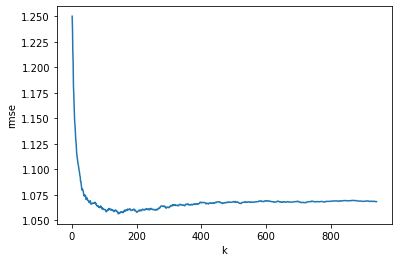

In [ ]:
import matplotlib.pyplot as plt


plt.plot(xs, ys)
plt.xlabel('k')
plt.ylabel('rmse')
plt.show()

And find the optimal `k` (the `k` with the smallest RMSE value)

In [ ]:
optimal_k = xs[ys.index(min(ys))]

print("The optimal k equals: {k} with RMSE: {rmse}".format(k=optimal_k, rmse = min(ys)))

The optimal k equals: 144 with RMSE: 1.0561342141488934


# Recommendation

We know the optimal k, so now we can use it to recommend movies for users

Let's define function which takes neighbors dictionary, k, n and user id and returns list of size n with no rated movies ordered by predicted rating.

In [ ]:
def recommend_for_user(ratings_matrix, neighbors_dict, k, n, user_id):
  user_ratings = ratings_matrix[user_id]
  unrated_movies = np.where(user_ratings == 0)[0][1:]

  predicted_ratings = [(predict_rating(neighbors_dict, k, user_id, movie_id), movie_id) for movie_id in unrated_movies]
  valid_predicted_ratings = np.array([rating for rating in predicted_ratings if rating[0] is not None])

  sorted_predicted_ratings = valid_predicted_ratings[valid_predicted_ratings[:, 0].argsort()[::-1]]

  sorted_movies = np.array([prediction_with_movie[1] for prediction_with_movie in sorted_predicted_ratings])

  return sorted_movies[:n]

Let's set our N:

In [ ]:
recommendation_N = 10

Let's fill rating matrix with all ratings:

In [88]:
def insert_rating_into_all_ratings_matrix(movie_rates_element):
  user_id = movie_rates_element[1]
  movie_id = movie_rates_element[2]
  rating = movie_rates_element[3]

  all_ratings_matrix[user_id][movie_id] = rating

In [92]:
all_ratings_matrix = np.zeros((N+1, M+1), dtype=np.float)

[insert_rating_into_all_ratings_matrix(element) for element in movie_rates.itertuples()]

print(all_ratings_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 5. 3. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 ...
 [0. 5. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]]


Now we can recommend movies for all users!

In [93]:
recommendations_for_users = [(user_id, 
                              recommend_for_user(all_ratings_matrix,
                                                 given_ratings_dict,
                                                 optimal_k,
                                                 recomendation_N,
                                                 user_id)) for user_id in range(1, N+1)]

Streaming output truncated to the last 5000 lines.
Not enough data to predict rating for user: 941 of movie: 830. Skipping.
Predicting movie rating for user: 941 and movie: 831 with k: 144
Predicting movie rating for user: 941 and movie: 832 with k: 144
Predicting movie rating for user: 941 and movie: 833 with k: 144
Predicting movie rating for user: 941 and movie: 834 with k: 144
Predicting movie rating for user: 941 and movie: 835 with k: 144
Not enough data to predict rating for user: 941 of movie: 835. Skipping.
Predicting movie rating for user: 941 and movie: 836 with k: 144
Not enough data to predict rating for user: 941 of movie: 836. Skipping.
Predicting movie rating for user: 941 and movie: 837 with k: 144
Predicting movie rating for user: 941 and movie: 838 with k: 144
Not enough data to predict rating for user: 941 of movie: 838. Skipping.
Predicting movie rating for user: 941 and movie: 839 with k: 144
Not enough data to predict rating for user: 941 of movie: 839. Skipping.

And create a pretty table:

In [94]:
from prettytable import PrettyTable


table = PrettyTable()
table.field_names = ["user id", "recommendations"]

for (movie_id, recommendations) in recommendations_for_users:
  table.add_row([movie_id, recommendations])

print(table)

+---------+-----------------------------------------------------+
| user id |                   recommendations                   |
+---------+-----------------------------------------------------+
|    1    | [1316 1467 1142 1367 1368 1500 1589 1114 1599  408] |
|    2    |      [504  98 923  45 601 603 419 960  51 615]      |
|    3    | [  93  658 1293  143  140  133  132  482  212  481] |
|    4    | [  86  562  528  884 1101  971  923  313  921 1188] |
|    5    | [1169 1278 1269  900  318 1500  896 1367  868  814] |
|    6    | [ 884 1449 1114  603  851 1201 1599 1202 1589 1367] |
|    7    | [1114 1202  814 1367 1368  169  884 1449 1201 1536] |
|    8    | [ 119 1189 1495  285 1278  882 1282  543 1114 1473] |
|    9    | [ 170 1536 1201 1252  251  127 1171 1114 1512   57] |
|    10   | [ 253  534 1449  884 1467 1473 1114  169 1512 1368] |
|    11   | [ 814 1398  868  127  534  251  483 1599 1443  884] |
|    12   | [1443 1599 1368  178  838  534   64 1064 1450  596] |
|    13   

# **UNIT TESTS**
(some sort of TDD)

# [test #1]

`training_movie_rates` maping to `given_ratings_matrix` test

In [ ]:
def assert_given_ratings_value(training_rate_element):
  user_id = training_rate_element[1]
  movie_id = training_rate_element[2]
  expected_rating = training_rate_element[3]

  matrix_value = given_ratings_matrix[user_id][movie_id]

  assert matrix_value == expected_rating

In [ ]:
[assert_given_ratings_value(element) for element in training_movie_rates.itertuples()]

print("Test #1 passed!")

Test #1 passed!


# [test #2]

`create_neighbors_dict` method test

In [ ]:
given_ratings = np.array([[0, 0, 0, 0, 0, 0],
                          [0, 2, 3, 0, 5, 1],
                          [0, 1, 0, 0, 3, 0],
                          [0, 1, 1, 1, 2, 0],
                          [0, 4, 3, 5, 4, 3],
                          [0, 1, 2, 3, 1, 2]], dtype=np.float)

expected_order_for_user_1 = np.array([[1, 1, 1, 2, 0],
                                      [1, 0, 0, 3, 0],
                                      [4, 3, 5, 4, 3],
                                      [1, 2, 3, 1, 2]], dtype=np.float)

expected_order_for_user_2 = np.array([[2, 3, 0, 5, 1],
                                      [1, 1, 1, 2, 0],
                                      [4, 3, 5, 4, 3],
                                      [1, 2, 3, 1, 2]], dtype=np.float)

expected_order_for_user_3 = np.array([[2, 3, 0, 5, 1],
                                      [4, 3, 5, 4, 3],
                                      [1, 0, 0, 3, 0],
                                      [1, 2, 3, 1, 2]], dtype=np.float)

expected_order_for_user_4 = np.array([[1, 2, 3, 1, 2],
                                      [1, 1, 1, 2, 0],
                                      [2, 3, 0, 5, 1],
                                      [1, 0, 0, 3, 0]], dtype=np.float)

expected_order_for_user_5 = np.array([[4, 3, 5, 4, 3],
                                      [1, 1, 1, 2, 0],
                                      [2, 3, 0, 5, 1],
                                      [1, 0, 0, 3, 0]], dtype=np.float)

expected_dict = dict([(1, expected_order_for_user_1),
                      (2, expected_order_for_user_2),
                      (3, expected_order_for_user_3),
                      (4, expected_order_for_user_4),
                      (5, expected_order_for_user_5)])

In [ ]:
result = create_neighbors_dict(given_ratings)

assert (result[1][:, 1:] == expected_order_for_user_1).all()
assert (result[2][:, 1:] == expected_order_for_user_2).all()
assert (result[3][:, 1:] == expected_order_for_user_3).all()
assert (result[4][:, 1:] == expected_order_for_user_4).all()
assert (result[5][:, 1:] == expected_order_for_user_5).all()

print("Test #2 passed!")

Sorting neighbors for user: 1
Sorting neighbors for user: 2
Sorting neighbors for user: 3
Sorting neighbors for user: 4
Sorting neighbors for user: 5
Test #2 passed!


# [test #3]

In [ ]:
given_dict = expected_dict

given_user_id = 3
given_k = 3

expected_result = np.array([[2, 3, 0, 5, 1],
                            [4, 3, 5, 4, 3],
                            [1, 0, 0, 3, 0]], dtype=np.float)

In [ ]:
result = get_k_nearest_neighbors_for_user(given_dict, given_k, given_user_id)

assert (result == expected_result).all()

print("Test #3 passed!")

Test #3 passed!
